In [2]:
# Enhanced Imports
from keras import models, layers, regularizers, callbacks
from keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os, warnings
from PIL import Image
import pandas as pd
import keras

# Suppress Warnings for Cleaner Output
warnings.simplefilter('ignore')

# Data Acquisition Function
def load_data(file_paths):
    return [np.load(path) for path in file_paths]

# Dataset File Paths
data_paths = [
    'C:/Datasets/eda-and-data-preprocessing/train_images.npy',
    'C:/Datasets/eda-and-data-preprocessing/train_labels.npy',
    'C:/Datasets/eda-and-data-preprocessing/train_images_third.npy',
    'C:/Datasets/eda-and-data-preprocessing/train_labels_third.npy',
    'C:/Datasets/eda-and-data-preprocessing/val_images.npy',
    'C:/Datasets/eda-and-data-preprocessing/val_labels.npy',
    'C:/Datasets/eda-and-data-preprocessing/test_images.npy',
    'C:/Datasets/eda-and-data-preprocessing/test_labels.npy'
]

# Load and Explore Data
train_images, train_labels, train_images_third, train_labels_third, val_images, val_labels, test_images, test_labels = load_data(data_paths)
dataset_shapes = {
    "Training": train_images.shape,
    "Validation": val_images.shape,
    "Testing": test_images.shape
}
for key, value in dataset_shapes.items():
    print(f"{key} Data Shape: {value}")

# Visualization Function with Enhanced Structure
def plot_results(history):
    metrics = ['loss', 'accuracy', 'recall', 'auc']
    phases = ['train', 'val']
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        for phase in phases:
            plt.plot(history.history[f'{phase}_{metric}'], label=f'{phase} {metric}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
#Explore the dataset again
print ("Number of training samples: " + str(train_images.shape[0]))
print ("A third of training samples: " + str(train_images_third.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("===")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("A third of train_images shape: " + str(train_images_third.shape))
print ("A third of train_labels shape: " + str(train_labels_third.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 25803
A third of training samples: 8601
Number of validation samples: 8602
Number of testing samples: 3823
===
train_images shape: (25803, 128, 128, 3)
train_labels shape: (25803,)
A third of train_images shape: (8601, 128, 128, 3)
A third of train_labels shape: (8601,)
val_images shape: (8602, 128, 128, 3)
val_labels shape: (8602,)
test_images shape: (3823, 128, 128, 3)
test_labels shape: (3823,)


In [6]:
#Build a pretrained ResNet50 model
resnet50 = ResNet50(weights='imagenet',
                   include_top=False, # Allows us to set input shape
                   input_shape=(128,128,3)) 

2021-11-30 01:15:46.783910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 01:15:46.877688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 01:15:46.878398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 01:15:46.880162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
#Add Resnet50 to our pretrained model
resnet50_model = keras.models.Sequential()
resnet50_model.add(resnet50)

#Freezing layers so they don't get re-trained with new data
for layer in resnet50_model.layers:
    layer.trainable=False 
    
#Adding our own dense layers
resnet50_model.add(layers.Flatten())
resnet50_model.add(layers.Dense(128, activation='relu'))

#Output Layer
resnet50_model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
#Compile resnet50 model
resnet50_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'Recall', 'AUC'])

#Instantiate an EarlyStopping Object
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_resnet50_model.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

#And fit the resnet50 to the training images, validating on the val images
results = resnet50_model.fit(train_images_third,
                            train_labels_third,
                            epochs=50,
                            batch_size=32,
                            callbacks = [es,mc],
                            validation_data=(val_images, val_labels))

2021-11-30 01:15:52.787856: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-11-30 01:15:54.714712: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-11-30 01:15:55.968233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-30 01:15:59.983778: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


269/269 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8714 - recall: 0.1415 - auc: 0.6937

2021-11-30 01:16:15.398313: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.
2021-11-30 01:16:17.322715: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.


269/269 [==============================] - 31s 82ms/step - loss: 0.3669 - accuracy: 0.8714 - recall: 0.1415 - auc: 0.6937 - val_loss: 0.3287 - val_accuracy: 0.8755 - val_recall: 0.1658 - val_auc: 0.8750

Epoch 00001: val_recall improved from -inf to 0.16575, saving model to best_resnet50_model.h5
Epoch 2/50
269/269 [==============================] - 15s 55ms/step - loss: 0.3089 - accuracy: 0.8897 - recall: 0.2829 - auc: 0.8018 - val_loss: 0.2837 - val_accuracy: 0.8907 - val_recall: 0.2885 - val_auc: 0.8892

Epoch 00002: val_recall improved from 0.16575 to 0.28851, saving model to best_resnet50_model.h5
Epoch 3/50
269/269 [==============================] - 15s 56ms/step - loss: 0.2856 - accuracy: 0.8997 - recall: 0.3678 - auc: 0.8334 - val_loss: 0.2724 - val_accuracy: 0.8987 - val_recall: 0.4253 - val_auc: 0.8961

Epoch 00003: val_recall improved from 0.28851 to 0.42533, saving model to best_resnet50_model.h5
Epoch 4/50
269/269 [==============================] - 15s 55ms/step - loss: 0.

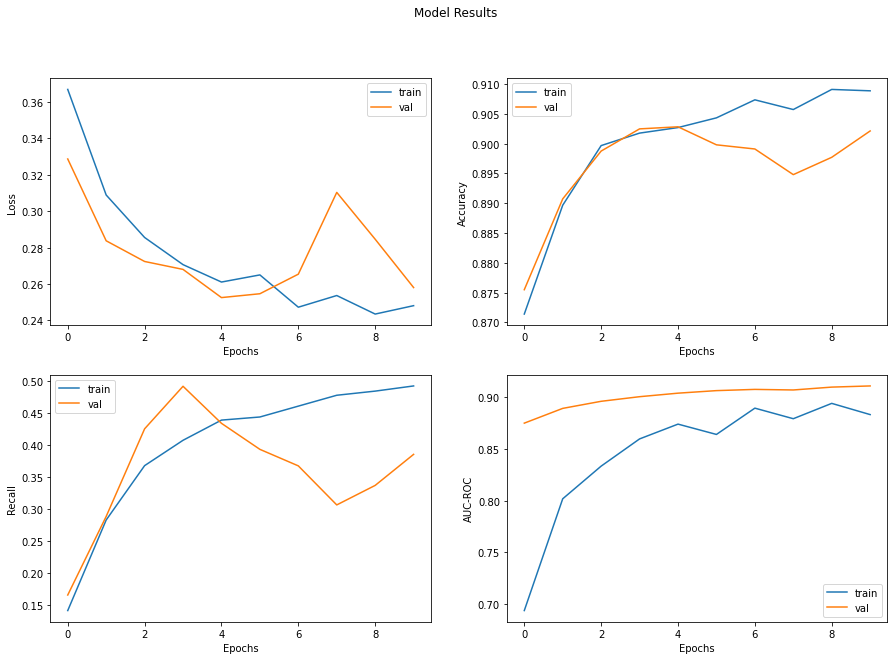

In [10]:
#Visualize Results 
plot_results(results)

In [11]:
#Save Weights
resnet50_model.save_weights('resnet50_model_weights.h5')